# LSA - Code

## Building the Term / Document matrix
LSA is a natural language processing method, it helps analysing a corpus of texts. A corpus of text is simply a collection of texts, to understand what follows we introduce a few terms :
* *Corpus :* the collection of texts to be analysed
* *Document :* how we will call a text in the corpus
* *Term :* how we will call individual words in the corpus

The object we need to build in order to run the LSA model is a term-document matrix, it is a matrix which rows represent all the words present in the corpus, the columns represent each document in the corpus, and the values contained in the matrix indicate a certain metric that quantifies the link between a given term with a given document. For example this metric may be the number of times that the term appears in a document. More commonly the metric that is used to build the term/document matrix is the term frequency inverse document frequency introduced in the first lecture (TfIdf) because of its ability to more accurately represent the relevance of each term in each document.

Let's create a toy example of corpus and walk you through the steps of building the term document matrix :

In [1]:
# Install spacy quietly
!pip install spacy -q

In [2]:
# Import libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

# TruncatedSVD from sklearn
from sklearn.decomposition import TruncatedSVD

# List of documents
a1 = "He is a good dog."
a2 = "The dog is too lazy."
a3 = "That is a brown cat."
a4 = "Cats are very active."
a5 = "I have brown cat and dog."

df = pd.DataFrame()
df["documents"] = [a1,a2,a3,a4,a5]
df

,documents
0,He is a good dog.
1,The dog is too lazy.
2,That is a brown cat.
3,Cats are very active.
4,I have brown cat and dog.


We are now going to run simple preprocessing on this simple corpus to make it suitable for our model :
* remove all special characters 
* convert all characters to lowercase

In [3]:
# Preprocessing
df['clean_documents'] = df['documents'].str.replace(r"[^A-Za-z0-9 ]+", " ")
df['clean_documents'] = df['clean_documents'].fillna('').apply(lambda x: x.lower())
df

,documents,clean_documents
0,He is a good dog.,he is a good dog
1,The dog is too lazy.,the dog is too lazy
2,That is a brown cat.,that is a brown cat
3,Cats are very active.,cats are very active
4,I have brown cat and dog.,i have brown cat and dog


Now that the text has been preprocessed, we will proceed to tokenization, which is the process of isolating each word in each document as a token, this will be a good opportunity to remove stop words tokens.

In [4]:
!python -m spacy download en -q

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/antoinekrajnc/opt/anaconda3/lib/python3.8/site-packages/en_core_web_sm
--> /Users/antoinekrajnc/opt/anaconda3/lib/python3.8/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [5]:
# Importing english
import en_core_web_sm
nlp = en_core_web_sm.load()

In [7]:
from spacy.lang.en.stop_words import STOP_WORDS

# tokenization
tokenized_doc = df['clean_documents'].fillna('').apply(lambda x: nlp(x))

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])
tokenized_doc

0          [good, dog]
1          [dog, lazy]
2         [brown, cat]
3        [cat, active]
4    [brown, cat, dog]
Name: clean_documents, dtype: object

Now that all our documents have been tokenized and cleaned, it is time to create ou term-document matrix giving the tf-idf for each term in each document. But first we have to re inject the cleaned documents in the DataFrame.

In [8]:
l = ["cat","dog"]
' '.join(l)

'cat dog'

In [9]:
# de-tokenization
detokenized_doc = []
for i in range(len(df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

df['clean_documents'] = detokenized_doc
df

,documents,clean_documents
0,He is a good dog.,good dog
1,The dog is too lazy.,dog lazy
2,That is a brown cat.,brown cat
3,Cats are very active.,cat active
4,I have brown cat and dog.,brown cat dog


In [10]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english', smooth_idf=True)
X = vectorizer.fit_transform(df['clean_documents'])
dense = X.toarray()
dense

array([[0.        , 0.        , 0.        , 0.55645052, 0.83088075,
        0.        ],
       [0.        , 0.        , 0.        , 0.55645052, 0.        ,
        0.83088075],
       [0.        , 0.76944707, 0.63871058, 0.        , 0.        ,
        0.        ],
       [0.83088075, 0.        , 0.55645052, 0.        , 0.        ,
        0.        ],
       [0.        , 0.64846263, 0.53828256, 0.53828256, 0.        ,
        0.        ]])

In [11]:
vectorizer.vocabulary_

{'good': 4, 'dog': 3, 'lazy': 5, 'brown': 1, 'cat': 2, 'active': 0}

Note that the obtained object is a sparse matrix. This format is often used when dealing with matrices with a very high number of elements equal to zero to save memory space and accelerate computation. The only drawback is that sparse object cannot be visualized.

## Apply truncatedSVD

Remember from theory that truncated SVD means that we can take the $k$ highest singular values to approximates a matrix $A$. 

Now if we only wish to select the highest $k$ out of the $l$ singular values $\sigma_1, ..., \sigma_l$ as well as the corresponding vectors from $U$ and $V$ we would obtain the best rank $k$ approximation of X, and we could map the word vector $t_i^T$ to its $k$ rank approxiamtion $\hat{t_i^T}_{(k)}$, and $\hat{d_j}$ to its $k$ rank approximation $\hat{d_j}_{(k)}$

You can now do the following:

* See how related documents $j$ and $q$ are in the low-dimensional space by comparing the vectors $\Sigma_{k} \hat{d_{j}}$ and $\Sigma_{k}\hat{d_q}$ (typically by [cosine similarity](https://en.wikipedia.org/wiki/Vector_space_model)).
* Comparing terms $i$ and $p$ by comparing the vectors $\Sigma_{k}\hat{t_{i}}$ and $\Sigma_{k}\hat{t_{p}}$. Note that $\hat{t}$ is now a column vector.
* Documents and term vector representations can be clustered using traditional clustering algorithms like k-means using similarity measures like cosine.

The $k$ dimensions retained for the low dimensional space are often referred to as topics even though their interpretation may be difficult.

Let's see how we can use the SVD in python in order to understand our corpus:



In [12]:
# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=2, algorithm='randomized', n_iter=100, random_state=122)
lsa = svd_model.fit_transform(X)

topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_1", "topic_2"])
topic_encoded_df["documents"] = df['clean_documents']
topic_encoded_df

,topic_1,topic_2,documents
0,0.341383,0.719978,good dog
1,0.341383,0.719978,dog lazy
2,0.860949,-0.365984,brown cat
3,0.516666,-0.385005,cat active
4,0.949412,0.023630,brown cat dog


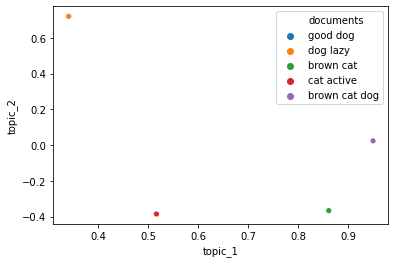

In [13]:
import seaborn as sns
sns.scatterplot("topic_1","topic_2",data= topic_encoded_df, hue = "documents")

In [17]:
dic = vectorizer.vocabulary_
dic_sorted = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1])}
dic_sorted.keys()

dict_keys(['active', 'brown', 'cat', 'dog', 'good', 'lazy'])

In [18]:
sorted(dic.items(), key=lambda item: item[1])

[('active', 0), ('brown', 1), ('cat', 2), ('dog', 3), ('good', 4), ('lazy', 5)]

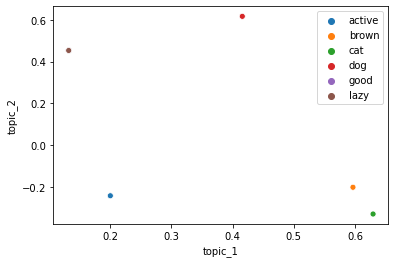

In [19]:
topic = pd.DataFrame(svd_model.components_, index = ["topic_1","topic_2"])
topic.columns= dic_sorted.keys()
topic_t = topic.transpose()

import seaborn as sns
sns.scatterplot("topic_1","topic_2",data= topic_t, hue = topic_t.index)

In [20]:
svd_model.explained_variance_ratio_

array([0.10893162, 0.40096526])

For example here, we used the SVD in order to approximate the term-document matrix with a decomposition of rank 2, and we can see how each document (sentence) is projected across these two topics.

Here we notice that topic 1 tends to be more linked to cat and topic 2 is more linked with dog.

## Resources 📚📚

*   <a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html?highlight=truncated%20svd#sklearn.decomposition.TruncatedSVD" target="_blank">Truncated SVD</a>

*   <a href="https://scikit-learn.org/stable/modules/decomposition.html#lsa" target="_blank">Truncated singular value decomposition and latent semantic analysis</a>